### Todo and ideas

#TODO: Assign Timestamp : Month/day/hour. check pandas timeseries libraries -> transform into timeseries. can transform hourly -> daily etc.
#Clean out columns in new dataframe have both long and abbreviated labels
#Weather, system capacity -> indoor temperature/comfort
#Outlier/most problematic days hour by hour

#Isolate days that exceed capacity

#Smoothing data: 24 hour high/low, can restrict to heating/cooling? 
#Average based on time of day
#Document challenges i.e. breaking down temperature between and inside days

- Drop or hide months with high volatility. Show just heating and cooling season
- Day by day period? Temperature within a day in a season
- Fill space between high/low. 
- Is there ever a day where temperature is out of range on both ends? New column for in high/low temp range. # of hours outside of range within a day.  Regular vs problematic days. Most extreme day in each month?
- Within day: point color coding failed too hot/too cold, size based on # of hours
- Roll for every hour in each day? Can create synthetic day in january 
- Heatmap/tile visualization (think calendar), color code/intensity based on how long out of range/on what end

Make new labels for rows -> can query later
- Week/day num from timestamp for calendar
- Timestamp, middle of each hour. Enables condensed axis etc. 

Look into larger time series i.e. several years


In [33]:
# Importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
# Cleaning off first row and units
def clean_units(df):
    units_list = df.iloc[0]
    df = df.iloc[1:]

    # Cleaning units
    df = df.apply(pd.to_numeric)

    return df, units_list


In [35]:
# Importing Austin dataset as framework (unmet cooling only TODO:consider for both cooling and heating)
atx_df = pd.read_csv('BEopt Viz\\atx_unmet_results_timeseries.csv')
atx_df, units = clean_units(atx_df)
assert atx_df.shape[0] == 365*24 #asserting that each row is one hour our of the year
atx_df

C:\Users\micha\AppData\Local\Temp\ipykernel_22656\824823416.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82) have mixed types. Specify dtype option on import or set low_memory=False.
  atx_df = pd.read_csv('BEopt Viz\\atx_unmet_results_timeseries.csv')


,My Design - Energy Use| Total,My Design - Fuel Use| Electricity: Total,My Design - Fuel Use| Natural Gas: Total,My Design - End Use| Electricity: Heating,My Design - End Use| Electricity: Heating Heat Pump Backup,My Design - End Use| Electricity: Heating Fans/Pumps,My Design - End Use| Electricity: Cooling,My Design - End Use| Electricity: Cooling Fans/Pumps,My Design - End Use| Electricity: Lighting Interior,My Design - End Use| Electricity: Lighting Exterior,...,My Design - Temperature| Cooling Setpoint,My Design - Airflow| Infiltration,My Design - Airflow| Mechanical Ventilation,My Design - Airflow| Natural Ventilation,My Design - Weather| Drybulb Temperature,My Design - Weather| Wetbulb Temperature,My Design - Weather| Relative Humidity,My Design - Weather| Wind Speed,My Design - Weather| Diffuse Solar Radiation,My Design - Weather| Direct Solar Radiation
1,4.09,1.20,0.00,0.74,0.0,0.01,0.00,0.00,0.06,0.02,...,74,30.13,66.48,0.0,42.98,42.19,94,0.00,0.0,0.0
2,4.12,1.21,0.00,0.79,0.0,0.02,0.00,0.00,0.05,0.02,...,74,29.14,66.07,0.0,44.06,43.38,95,1.34,0.0,0.0
3,4.15,1.22,0.00,0.81,0.0,0.02,0.00,0.00,0.05,0.02,...,74,28.90,65.87,0.0,44.96,44.41,96,4.70,0.0,0.0
4,5.58,1.21,1.45,0.82,0.0,0.02,0.00,0.00,0.05,0.01,...,74,29.88,65.67,0.0,46.04,44.62,90,8.05,0.0,0.0
5,4.19,1.23,0.00,0.82,0.0,0.02,0.00,0.00,0.05,0.01,...,74,33.13,65.87,0.0,46.94,44.46,83,11.63,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,6.98,1.61,1.49,0.00,0.0,0.00,0.32,0.09,0.50,0.03,...,74,21.68,70.58,0.0,69.08,64.37,78,14.99,0.0,0.0
8757,6.57,1.49,1.49,0.00,0.0,0.00,0.26,0.08,0.52,0.03,...,74,19.70,70.68,0.0,68.00,64.02,81,13.87,0.0,0.0
8758,5.71,1.24,1.49,0.00,0.0,0.00,0.21,0.06,0.38,0.03,...,74,17.19,70.88,0.0,68.00,64.67,84,12.75,0.0,0.0
8759,4.51,0.89,1.47,0.00,0.0,0.00,0.15,0.04,0.19,0.02,...,74,19.83,69.88,0.0,68.00,64.67,84,13.87,0.0,0.0


In [36]:
# Slicing out only wanted columns and labels and changing to datetime
full_labels_list = atx_df.columns.tolist()

living_space_columns = ['My Design - Temperature| Living Space', 'My Design - Temperature| Heating Setpoint', 'My Design - Temperature| Cooling Setpoint']
short_labels = ['living_space_temp', 'heating_setpoint', 'cooling_setpoint'] #temps in F
# Creating date range
date_range = pd.date_range(start="2023-01-01", end="2024-01-01", freq="1H", inclusive="left")

living_df = (atx_df[living_space_columns].set_axis(short_labels, axis=1) # slicing and renaming columns
                                         .set_index(date_range))         # changing to hourly index
            
assert living_df.shape[0] == 365*24
living_df.head()


,living_space_temp,heating_setpoint,cooling_setpoint
2023-01-01 00:00:00,72.0,72,74
2023-01-01 01:00:00,72.0,72,74
2023-01-01 02:00:00,72.0,72,74
2023-01-01 03:00:00,72.0,72,74
2023-01-01 04:00:00,72.0,72,74


In [37]:
# Adding columns: deviation over/under the heating/cooling setpoint

setpoint_diff = living_df['cooling_setpoint'] - living_df['heating_setpoint']
living_df['heating_deviation'] = living_df['living_space_temp'] - living_df['heating_setpoint']
living_df['cooling_deviation'] = living_df['living_space_temp'] - living_df['cooling_setpoint']

# True if the temperature is below the heating setpoint or above the cooling setpoint.
living_df['exceeds_setpoints'] = np.where((living_df['living_space_temp'] > living_df['cooling_setpoint']) | (living_df['living_space_temp']<living_df['heating_setpoint']), True, False)

# Slicing a dataframe with timepoints that exceed the temperature setpoints
#excess_df = living_df[living_df['exceeds_setpoints'] == True]

In [38]:
# Make new column for too hot, to cold, or in range
range_conditions = [living_df['living_space_temp'] < living_df['heating_setpoint'], living_df['living_space_temp'] > living_df['cooling_setpoint'], (living_df['living_space_temp'].between(living_df['heating_setpoint'], living_df['cooling_setpoint']))]
range_choices = ['Too Cold', 'Too Hot', 'In Range']
living_df['in_range'] = np.select(range_conditions, range_choices)


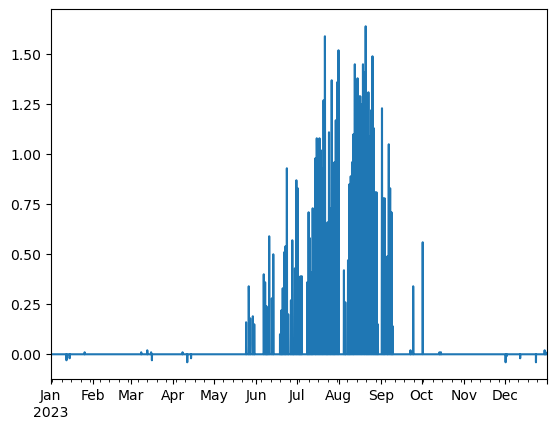

In [44]:
# Make new column for amount of excess degrees, 0 if within comfortable range.
excess_conditions = [living_df['in_range'] == 'Too Hot', living_df['in_range'] == 'Too Cold', living_df['in_range'] == 'In Range']
excess_choices = [living_df['cooling_deviation'], living_df['heating_deviation'], 0]
living_df['excess_temp'] = np.select(excess_conditions, excess_choices)

too_hot_df = living_df[living_df['in_range'] == 'Too Hot'] # If exceeds, cooling_deviation is magnitude
too_cold_df = living_df[living_df['in_range'] == 'Too Cold'] # If exceeds, heating_deviation is magnitude

living_df.excess_temp.plot()
plt.show()

In [40]:
# Saving cleaned dataset
living_df.to_csv('atx_hourly_cleaned.csv')

In [41]:
import datetime as dt

# Condensing to day by day. For now, just using the mean values of each day.
living_dod_df = living_df.reset_index().rename(columns={'index': 'datetime'})
living_dod_df = living_dod_df.groupby([living_dod_df['datetime'].dt.date]).mean()

# TODO: Try rank windowing function to max/min excess temps 

living_dod_df


,living_space_temp,heating_setpoint,cooling_setpoint,heating_deviation,cooling_deviation,exceeds_setpoints,excess_temp
datetime,,,,,,,
2023-01-01,72.192500,72.0,74.0,0.192500,-1.807500,0.000000,0.000000
2023-01-02,72.592500,72.0,74.0,0.592500,-1.407500,0.000000,0.000000
2023-01-03,72.000000,72.0,74.0,0.000000,-2.000000,0.000000,0.000000
2023-01-04,72.472500,72.0,74.0,0.472500,-1.527500,0.000000,0.000000
2023-01-05,72.566250,72.0,74.0,0.566250,-1.433750,0.000000,0.000000
...,...,...,...,...,...,...,...
2023-12-27,72.420833,72.0,74.0,0.420833,-1.579167,0.000000,0.000000
2023-12-28,72.715417,72.0,74.0,0.715417,-1.284583,0.000000,0.000000
2023-12-29,73.222917,72.0,74.0,1.222917,-0.777083,0.000000,0.000000


In [42]:
excess_df = living_dod_df[living_dod_df['exceeds_setpoints'] != 0]
excess_df

,living_space_temp,heating_setpoint,cooling_setpoint,heating_deviation,cooling_deviation,exceeds_setpoints,excess_temp
datetime,,,,,,,
2023-01-12,72.010417,72.0,74.0,0.010417,-1.989583,0.041667,-0.001250
2023-01-14,72.707083,72.0,74.0,0.707083,-1.292917,0.041667,-0.000833
2023-01-25,73.492500,72.0,74.0,1.492500,-0.507500,0.041667,0.000417
2023-03-08,72.631250,72.0,74.0,0.631250,-1.368750,0.041667,0.000417
2023-03-13,73.339583,72.0,74.0,1.339583,-0.660417,0.041667,0.000833
...,...,...,...,...,...,...,...
2023-12-02,73.004167,72.0,74.0,1.004167,-0.995833,0.041667,-0.000417
2023-12-12,72.854167,72.0,74.0,0.854167,-1.145833,0.041667,-0.000833
2023-12-24,73.112083,72.0,74.0,1.112083,-0.887917,0.041667,-0.001667


In [43]:
import calplot

excess_df.index = pd.to_datetime(excess_df.index)

# Plotting excess days on calendar heatmap
calplot.calplot(excess_df['deviation_from_avg'],suptitle = 'Calendar With Days Where Supplemental Cooling/Heating is Needed',cmap = 'bwr')


KeyError: 'deviation_from_avg'

This is an interesting visualization and it definitely helps create a sense of intuition on which days the home system would need additional cooling/heating. However, there is some information that it abstracts out, such as by how many degrees the home exceeds comfort levels, and how much energy the system is using. The visualization is also likely dependent on the aggregation method used, becuase in this case it is simply using the average day's temperature and degree of deviation. Further visualizations may want to aggregate into average daily temperatures first and then find deviations, or use different aggregation methods.

Referring back to knowing particularly how much hotter or colder the home is exceeding limits: we can add labels to the cells, but at the cost of visual clutter.

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


(<Figure size 1250x170 with 2 Axes>,
 array([<AxesSubplot: ylabel='2023'>], dtype=object))

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


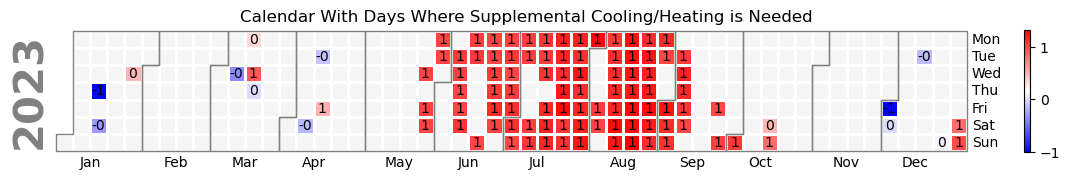

In [ ]:
calplot.calplot(excess_df['deviation_from_avg'], suptitle = 'Calendar With Days Where Supplemental Cooling/Heating is Needed',cmap = 'bwr',
                textformat= '{:.0f}', textfiller = '', textcolor = 'black')


This does add additional information, but because most of the temperature deviations above or below comfort range between 0 and 1, the smaller details are not as pronounced in this plot. This does help add intuition that even on the hottest days, however, the home is not rising or falling more than 1-2 degrees the set levels of comfort, which may be assuring to homeowners and contractors that their system is properly sized.

In [ ]:
#TODO: fix above logic error. deviation from average is centered around 1. For deviation above/below setpoint, need to subtract 1 from hot days and add 1 to cold days.
#TODO: make additional bool columns for excess heat/cooling?
#TODO: Try to group by max/min/absolute values maxed.
#text, in range, too hot, too cold. Calculate amount out of range (positive (too hot), 0 (in range), negative (too cold))
#Windowing function: window is the day. Can take row with largest magnitude out of range. Rank windowing function.
#Show single day / couple of days before calendar. Story with being in comfort vs out of range on either end
#Try different ranges for how bad it actually gets. squared/cubed of number of degrees out as heatmap value instead.

living_highlow_df = living_df.reset_index().rename(columns={'index': 'datetime'})
living_highlow_df = living_highlow_df.groupby([living_highlow_df['datetime'].dt.date]).max()
living_highlow_df

,datetime,living_space_temp,heating_setpoint,cooling_setpoint,energy_use,heating_deviation,cooling_deviation,deviation_from_avg,exceeds_setpoints,in_range
datetime,,,,,,,,,,
2023-01-01,2023-01-01 23:00:00,73.32,72,74,9.48,1.32,-0.68,0.32,False,In Range
2023-01-02,2023-01-02 23:00:00,74.00,72,74,8.72,2.00,0.00,1.00,False,In Range
2023-01-03,2023-01-03 23:00:00,72.00,72,74,11.02,0.00,-2.00,-1.00,False,In Range
2023-01-04,2023-01-04 23:00:00,74.00,72,74,13.82,2.00,0.00,1.00,False,In Range
2023-01-05,2023-01-05 23:00:00,74.00,72,74,13.96,2.00,0.00,1.00,False,In Range
...,...,...,...,...,...,...,...,...,...,...
2023-12-27,2023-12-27 23:00:00,74.00,72,74,13.86,2.00,0.00,1.00,False,In Range
2023-12-28,2023-12-28 23:00:00,74.00,72,74,9.52,2.00,0.00,1.00,False,In Range
2023-12-29,2023-12-29 23:00:00,74.00,72,74,7.09,2.00,0.00,1.00,False,In Range
